# Required libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# hana-ml classes
from hana_ml import ConnectionContext
from hana_ml.dataframe import create_dataframe_from_pandas, DataFrame
# Import OneClassSVM
from hana_ml.algorithms.pal.svm import OneClassSVM

# --- Connection Setup (Replace with your actual credentials) ---
# Please ensure these environment variables are set or replace the strings directly.
hana_address = os.getenv('hana_address', "<your_hana_address>")
hana_port = int(os.getenv('hana_port', 443)) # Use int() for port
hana_user = os.getenv('hana_user', "<your_hana_user>")
hana_password = os.getenv('hana_password', "<your_hana_password>")
hana_encrypt = os.getenv('hana_encrypt', 'true').lower() == 'true' # Handle boolean conversion
hana_schema = os.getenv('HANA_SCHEMA', 'AICOE') # Default schema or your specific one

# Establish connection
try:
    cc = ConnectionContext(
        address=hana_address,
        port=hana_port,
        user=hana_user,
        password=hana_password,
        encrypt=hana_encrypt,
        # Add sslValidateCertificate='false' if using self-signed certs and encryption
        # sslValidateCertificate='false',
        current_schema=hana_schema # Set the schema context
    )
    print(f"HANA Connection Test Successful: {cc.hana_version()}")
    print(f"Current Schema: {cc.get_current_schema()}")
except Exception as e:
    print(f"Error connecting to HANA: {e}")
    # Stop execution if connection fails
    raise SystemExit("HANA connection failed, please check credentials and settings.")

# --- Configuration for the Notebook ---
# Name for the HANA table we will create
TABLE_NAME = "SYNTHETIC_ANOMALY_DATA_OCSVM" # Changed table name
# Path to the generated data file
CSV_FILENAME = 'synthetic_anomaly_data.csv'
# Unique identifier column for HANA PAL functions
KEY_COL = 'ID'
# Ground truth column from the generator script
TRUTH_COL = 'is_anomaly'

ImportError: cannot import name 'display' from 'IPython.core.display' (/Users/I760054/Documents/programs/Best Practices/sap-btp-ai-best-practices/.venv/lib/python3.12/site-packages/IPython/core/display.py)


HANA Connection Test Successful: 4.00.000.00.1733217781 (fa/CE2024.28)
Current Schema: AICOE


# One-Class SVM with hana-ml

**Objective:** This notebook demonstrates how to use the `OneClassSVM` algorithm provided by the SAP HANA Predictive Analysis Library (PAL) via the `hana-ml` Python client (more documentation [here](https://help.sap.com/doc/1d0ebfe5e8dd44d09606814d83308d4b/2.0.07/en-US/pal/algorithms/hana_ml.algorithms.pal.svm.OneClassSVM.html#hana_ml.algorithms.pal.svm.OneClassSVM)). We will show how to train a One-Class SVM model for anomaly detection on a synthetically generated dataset.

**Algorithm Overview:**

One-Class Support Vector Machine (SVM) is an unsupervised algorithm primarily used for novelty or outlier detection. It learns a decision boundary that encompasses the majority of the training data (the "normal" points). New data points falling outside this boundary are classified as anomalies or outliers.

The algorithm aims to find a hyperplane in a high-dimensional feature space (potentially transformed by a kernel function) that separates the data points from the origin with maximum margin. Points lying on the "wrong" side of the hyperplane or too far from it are considered outliers.

**`hana_ml` Implementation:**

The `hana_ml.algorithms.pal.svm.OneClassSVM` class provides an interface to the PAL One-Class SVM function. 

**Key Parameters (`OneClassSVM` constructor):**

*   `nu` (float, optional, default=0.5): An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors. It roughly corresponds to the expected proportion of outliers in the dataset. Should be in the range (0, 1].
*   `kernel` (str, optional, default='rbf'): Specifies the kernel function to use. Common choices include:
    *   `'rbf'` (Radial Basis Function): Good general-purpose kernel.
    *   `'linear'`: For linearly separable data.
    *   `'poly'`: Polynomial kernel.
    *   `'sigmoid'`: Sigmoid kernel.
*   `gamma` (float, optional, default=1.0/n_features): Kernel coefficient for 'rbf', 'poly', and 'sigmoid'. If `None`, it defaults to `1 / n_features`.
*   `degree` (int, optional, default=3): Degree of the polynomial kernel function (`'poly'`). Ignored by other kernels.
*   `c` (float, optional, default=100.0): While less critical in OneClassSVM compared to standard SVM, it can influence the trade-off (though `nu` is the primary parameter). Value > 0.
*   `coef_lin` (float, optional, default=0): Coefficient for 'poly'/'sigmoid' kernels.
*   `coef_const` (float, optional, default=0): Independent term in kernel function ('poly'/'sigmoid').
*   `scale_info` (str, optional, default='standardization'): Specifies data scaling method before training. SVMs are sensitive to feature scaling.
    *   `'no'`: No scaling.
    *   `'standardization'`: Scale to zero mean and unit variance.
    *   `'rescale'`: Scale features to the range [-1, 1].
*   `tol` (float, optional, default=0.001): Tolerance for stopping criterion.
*   `shrink` (bool, optional, default=True): Whether to use the shrinking heuristic.
*   `handle_missing` (bool, optional, default=True): Whether PAL should handle missing values internally.
*   `thread_ratio` (float, optional, default=0.0): Controls the percentage of CPU threads used by PAL (0.0 to 1.0). 0.0 means single-threaded by default in this specific function documentation, -1.0 often lets PAL decide heuristically in other functions.

## 1. Data Loading and Preparation

First, we load the synthetic data generated by `anomaly_generator.py` into a pandas DataFrame and then upload it to SAP HANA.

In [2]:
# Load data from CSV
try:
    df_local = pd.read_csv(CSV_FILENAME)
    print(f"Successfully loaded '{CSV_FILENAME}' with shape {df_local.shape}")
except FileNotFoundError:
    print(f"Error: The file '{CSV_FILENAME}' was not found.")
    print("Please run the 'anomaly_generator.py' script first to create the data.")
    # Stop execution
    raise SystemExit("Input data file not found.")

# Add a unique ID column required by many PAL functions
if KEY_COL not in df_local.columns:
    df_local.insert(0, KEY_COL, range(len(df_local)))
    print(f"Added unique '{KEY_COL}' column.")

# Identify feature columns (assuming they start with 'feature_')
feature_cols = [col for col in df_local.columns if col.startswith('feature_')]
if not feature_cols:
     raise ValueError("No columns starting with 'feature_' found. Check data generation script or naming.")
print(f"Identified Feature Columns: {feature_cols}")

# Display basic info and head of the local DataFrame
print("\nLocal DataFrame Info:")
df_local.info()
print("\nLocal DataFrame Head:")
print(df_local.head())
print("\nAnomaly Distribution (Ground Truth):")
print(df_local[TRUTH_COL].value_counts(normalize=True))

# Calculate the actual contamination level from the ground truth
# This will be used to set the 'nu' parameter for OneClassSVM
actual_contamination = df_local[TRUTH_COL].mean()
# Ensure nu is slightly above 0 if actual_contamination is 0
nu_param = float(max(actual_contamination, 1e-6))
print(f"\nActual contamination in the dataset: {actual_contamination:.4f}")
print(f"Using nu parameter: {nu_param:.4f}")


# --- Upload data to HANA ---
# Drop the table if it exists before creating a new one
try:
    cc.drop_table(TABLE_NAME)
    print(f"Dropped existing table '{TABLE_NAME}' (if any).")
except Exception:
    print(f"Table '{TABLE_NAME}' does not exist yet, proceeding.")

# Create HANA DataFrame from pandas DataFrame
print(f"\nUploading data to HANA table '{TABLE_NAME}'...")
try:
    # Using force=True and replace=True ensures the table matches the pandas DF exactly
    hdf_input = create_dataframe_from_pandas(
        connection_context=cc,
        pandas_df=df_local,
        table_name=TABLE_NAME,
        force=True,
        replace=True,
        primary_key=KEY_COL # Setting primary key can improve performance
    )
    print(f"Successfully created HANA DataFrame: {hdf_input.select(KEY_COL).count()} rows.")
    # Display info about the HANA DataFrame
    print("\nHANA DataFrame Info (selected columns):")
    print(hdf_input.select(KEY_COL, TRUTH_COL, *feature_cols).head(5).collect())

except Exception as e:
    print(f"Error uploading data to HANA: {e}")
    raise SystemExit("Failed to create HANA DataFrame.")

Successfully loaded 'synthetic_anomaly_data.csv' with shape (1050, 6)
Added unique 'ID' column.
Identified Feature Columns: ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']

Local DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          1050 non-null   int64  
 1   feature_1   1050 non-null   float64
 2   feature_2   1050 non-null   float64
 3   feature_3   1050 non-null   float64
 4   feature_4   1050 non-null   float64
 5   feature_5   1050 non-null   float64
 6   is_anomaly  1050 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 57.6 KB

Local DataFrame Head:
   ID  feature_1  feature_2  feature_3  feature_4  feature_5  is_anomaly
0   0  18.277572  48.592749  43.922557  42.893798  13.340332           0
1   1  22.595480  45.241644  34.772461  29.038658  15.248534           0
2   2  20.127974  4

ERROR:hana_ml.dataframe:Fail to drop table. (259, 'invalid table name: SYNTHETIC_ANOMALY_DATA_OCSVM: line 1 col 20 (at pos 19)')


Dropped existing table 'SYNTHETIC_ANOMALY_DATA_OCSVM' (if any).

Uploading data to HANA table 'SYNTHETIC_ANOMALY_DATA_OCSVM'...


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Successfully created HANA DataFrame: 1050 rows.

HANA DataFrame Info (selected columns):
   ID  is_anomaly  feature_1  feature_2  feature_3  feature_4  feature_5
0   0           0  18.277572  48.592749  43.922557  42.893798  13.340332
1   1           0  22.595480  45.241644  34.772461  29.038658  15.248534
2   2           0  20.127974  48.403411  23.545939  33.311360  -2.885488
3   3           0  16.412641  45.087063  47.438820  31.308031  26.548545
4   4           0  17.728823  47.785572  29.888634  17.650589  -1.527156


## 2. Training the One-Class SVM Model

Now, we instantiate the `OneClassSVM` class from `hana-ml` and train it using the `fit()` method on our HANA DataFrame.

In [3]:
# Instantiate the One-Class SVM model
# We use the 'actual_contamination' calculated earlier to set 'nu'.
# Using default 'rbf' kernel and 'standardization' scaling.
ocsvm = OneClassSVM(
    nu=nu_param,           # Expected fraction of outliers
    kernel='rbf',          # Default kernel
    gamma=None,            # Use default gamma (1/n_features)
    scale_info='standardization', # Default and recommended scaling
    # random_state=42,     # random_state is for parameter selection, not basic fit
    thread_ratio=0.8       # Example: use 80% of threads
)

print("One-Class SVM model instantiated")

# Train the model
# The fit method requires the data, key, and features.
print("\nTraining the One-Class SVM model...")
try:
    # Fit the model to the data in HANA
    ocsvm.fit(data=hdf_input, key=KEY_COL, features=feature_cols)
    print("Model training completed successfully.")
except Exception as e:
    print(f"Error during model training: {e}")
    raise SystemExit("Model training failed.")


One-Class SVM model instantiated

Training the One-Class SVM model...
Model training completed successfully.


## 3. Predicting Anomalies

With the trained model, we use the `predict()` method to obtain anomaly scores and labels for data points.

**Key Parameters (`predict` method):**

*   `data` (DataFrame): The HANA DataFrame containing the data to score.
*   `key` (str): The name of the ID column in the `data` DataFrame.
*   `features` (list of str, optional): List of feature columns for prediction. If None, uses the same features as during `fit`.


In [4]:
# Predict anomaly scores and labels
print(f"\nPredicting anomalies using the trained One-Class SVM model...")

try:
    # The predict method returns a results DataFrame.
    results_hdf = ocsvm.predict(
        data=hdf_input, # Can predict on the same or new data
        key=KEY_COL,
        features=feature_cols # Optional, defaults to features used in fit
    )

    print("Prediction completed.")

    # Check the results DataFrame
    if results_hdf:
        print("\nPrediction Results (HANA DataFrame Head):")
        # Collect results into a pandas DataFrame for analysis
        df_results = results_hdf.collect()
        # Evaluate SCORE column from string to int
        df_results['SCORE'] = df_results['SCORE'].astype(int)
        print(df_results.head())

        print("\nPrediction Results Info:")
        df_results.info()

        # Check the structure assumption: ID, SCORE, PROBABILITY
        # SCORE: Predicted class. Assumed to be -1 for outlier, 1 for inlier.

        if 'SCORE' in df_results.columns:
            print("\nPredicted Label Distribution:")
            print(df_results['SCORE'].value_counts())
        else:
            print("\nWarning: 'SCORE' column not found in prediction results. Evaluation might fail.")

    else:
        print("Prediction did not return a results DataFrame.")

except Exception as e:
    print(f"Error during prediction: {e}")
    raise SystemExit("Prediction failed.")


Predicting anomalies using the trained One-Class SVM model...
Prediction completed.

Prediction Results (HANA DataFrame Head):
   ID  SCORE PROBABILITY
0   0      1        None
1   1      1        None
2   2      1        None
3   3      1        None
4   4      1        None

Prediction Results Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           1050 non-null   int64 
 1   SCORE        1050 non-null   int64 
 2   PROBABILITY  0 non-null      object
dtypes: int64(2), object(1)
memory usage: 24.7+ KB

Predicted Label Distribution:
SCORE
 1    1003
-1      47
Name: count, dtype: int64


## 4. Evaluating the Results

Since our synthetic dataset includes ground truth labels (`is_anomaly`), we can evaluate the performance of the One-Class SVM model. We merge the prediction results with the original data and calculate common metrics.


Merging predictions with ground truth...

Merged DataFrame Head (with truth and prediction):
   ID  is_anomaly  SCORE  predicted_anomaly
0   0           0      1                  0
1   1           0      1                  0
2   2           0      1                  0
3   3           0      1                  0
4   4           0      1                  0

--- Classification Report ---
              precision    recall  f1-score   support

  Normal (0)       0.99      0.99      0.99      1000
 Anomaly (1)       0.77      0.72      0.74        50

    accuracy                           0.98      1050
   macro avg       0.88      0.85      0.86      1050
weighted avg       0.98      0.98      0.98      1050


--- Confusion Matrix ---
[[989  11]
 [ 14  36]]


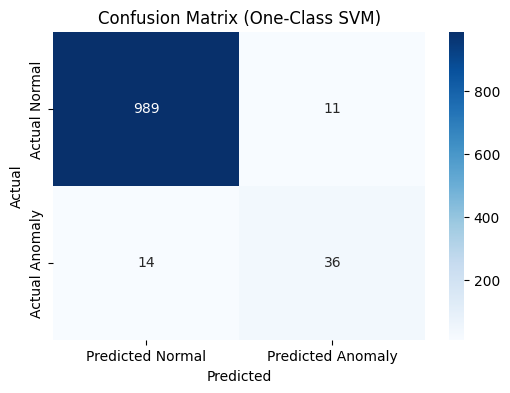

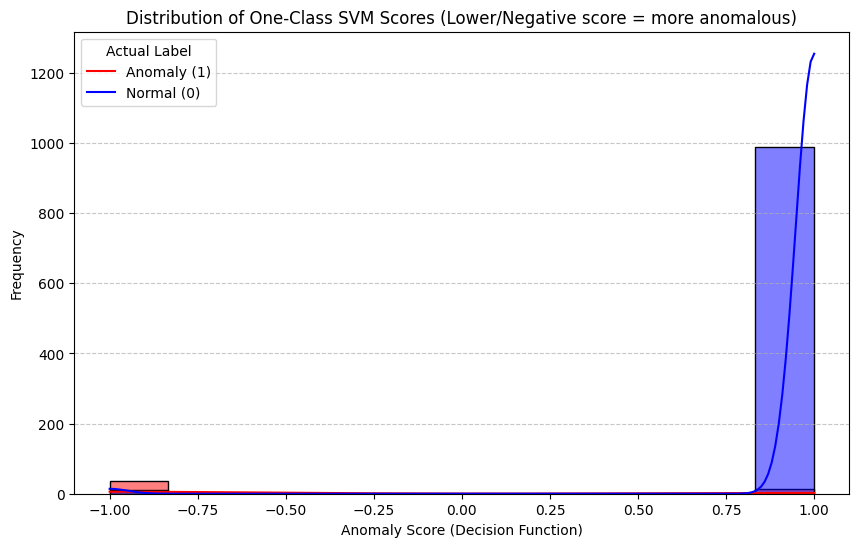

In [5]:
# Ensure we have the results and the assumed 'LABEL' column
if 'df_results' not in locals() or df_results is None:
     raise SystemExit("Prediction results are not available for evaluation.")
if 'SCORE' not in df_results.columns:
     raise SystemExit("Required 'SCORE' column not found in prediction results for evaluation.")

# Merge predictions with the original local data (which has the ground truth)
print("\nMerging predictions with ground truth...")
df_merged = pd.merge(df_local[[KEY_COL, TRUTH_COL]], df_results, on=KEY_COL)

# The model's SCORE is assumed to be -1 for outliers and 1 for inliers.
# Our ground truth TRUTH_COL is 1 for anomalies (outliers) and 0 for normal (inliers).
# Make sure SCORE column is integer type for comparison
df_merged['SCORE'] = df_merged['SCORE'].astype(int)
# Map the predicted LABEL to match the ground truth format (0 or 1).
df_merged['predicted_anomaly'] = df_merged['SCORE'].apply(lambda x: 1 if x == -1 else 0)

print("\nMerged DataFrame Head (with truth and prediction):")
# Display relevant columns: ID, ground truth, score, predicted label (-1/1), mapped prediction (0/1)
print(df_merged[[KEY_COL, TRUTH_COL, 'SCORE', 'predicted_anomaly']].head())

# --- Performance Metrics ---
print("\n--- Classification Report ---")
# Compare ground truth (is_anomaly) with the mapped prediction (predicted_anomaly)
print(classification_report(df_merged[TRUTH_COL], df_merged['predicted_anomaly'], target_names=['Normal (0)', 'Anomaly (1)']))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(df_merged[TRUTH_COL], df_merged['predicted_anomaly'])
print(cm)
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Anomaly'], yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (One-Class SVM)')
plt.show()


# --- Score Distribution ---
# Visualize the distribution of anomaly scores for actual normal vs. actual anomaly points
plt.figure(figsize=(10, 6))
sns.histplot(data=df_merged, x='SCORE', hue=TRUTH_COL, kde=True, palette={0: 'blue', 1: 'red'})
plt.title('Distribution of One-Class SVM Scores (Lower/Negative score = more anomalous)')
plt.xlabel('Anomaly Score (Decision Function)')
plt.ylabel('Frequency')
# Add legend manually if needed or rely on seaborn's default
plt.legend(title='Actual Label', labels=['Anomaly (1)', 'Normal (0)']) # Adjust labels based on plot order if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


--- Visualizing Predictions vs. Ground Truth ---

Generating pair plot for prediction analysis...


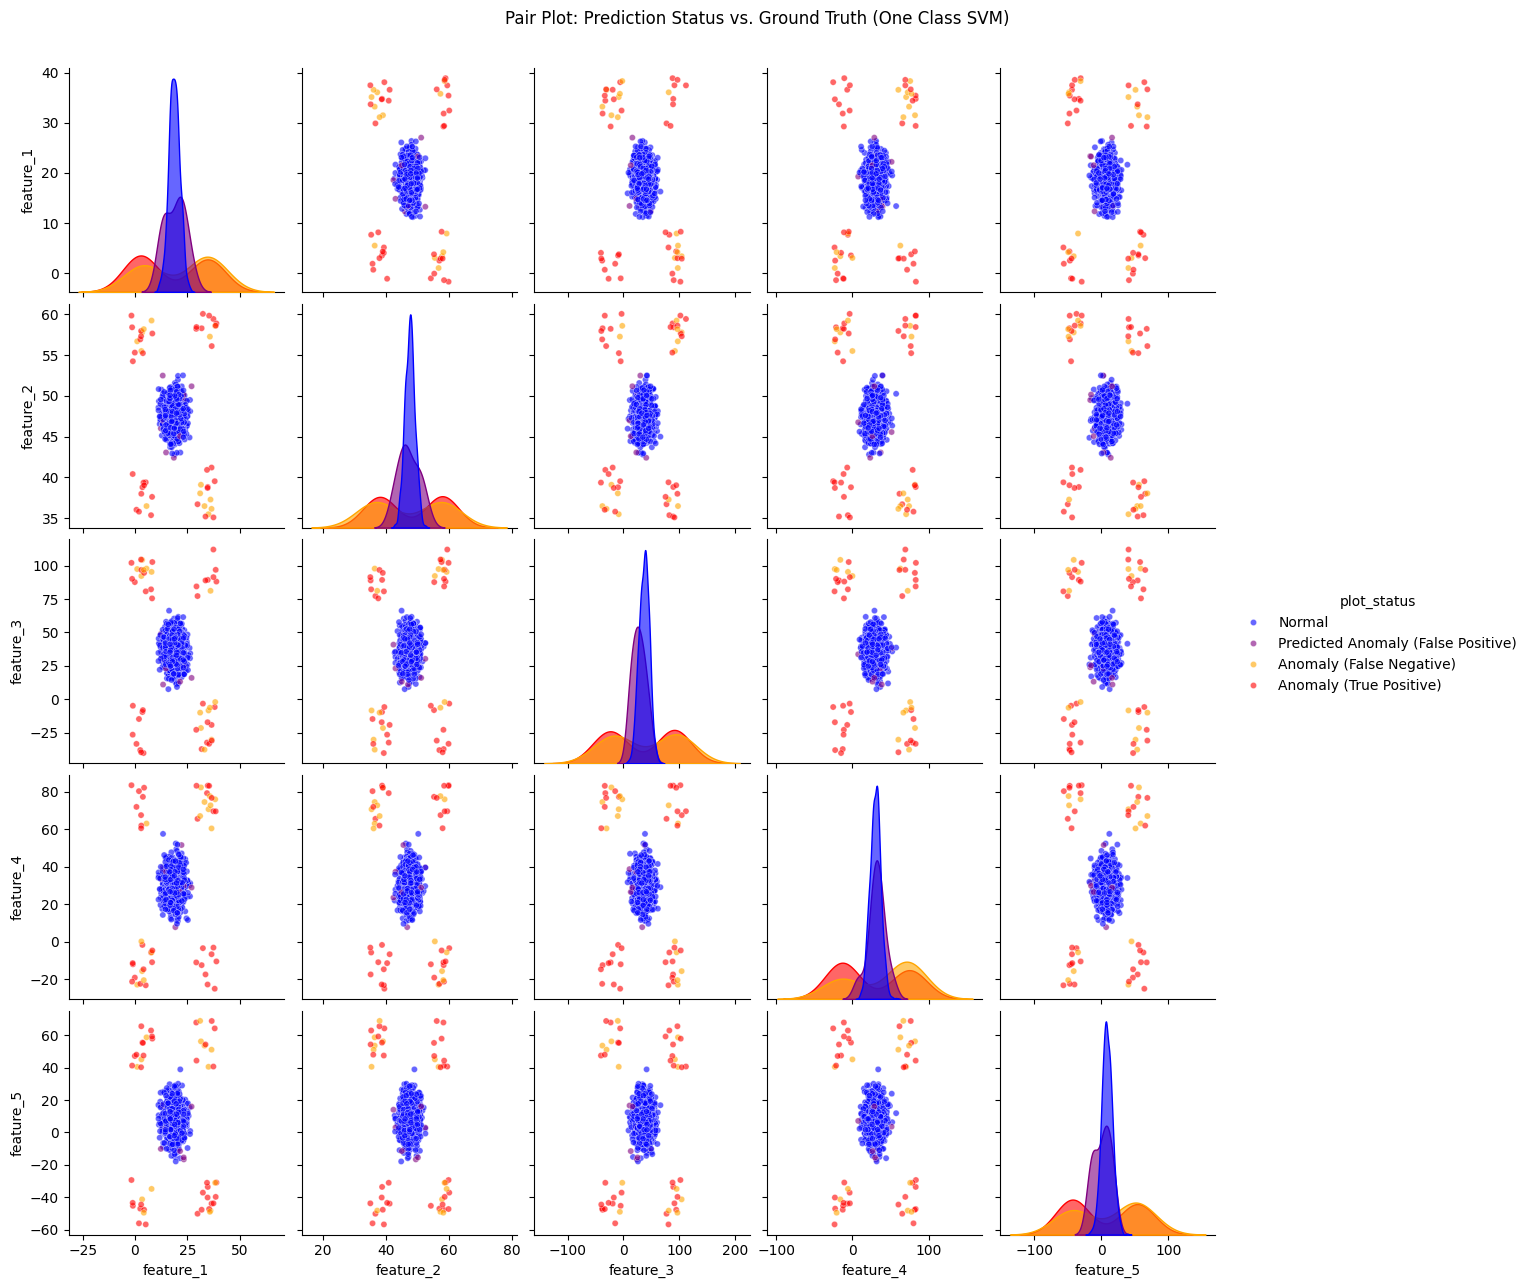

In [6]:
# --- Prediction Visualization (Pair Plot) ---
print("\n--- Visualizing Predictions vs. Ground Truth ---")

# Define a function to map status based on truth and prediction
def assign_plot_status(row):
    if row[TRUTH_COL] == 0 and row['predicted_anomaly'] == 0:
        return 'Normal'
    elif row[TRUTH_COL] == 1 and row['predicted_anomaly'] == 1:
        return 'Anomaly (True Positive)'
    elif row[TRUTH_COL] == 1 and row['predicted_anomaly'] == 0:
        return 'Anomaly (False Negative)' # Missed by model
    elif row[TRUTH_COL] == 0 and row['predicted_anomaly'] == 1:
        return 'Predicted Anomaly (False Positive)' # Incorrectly flagged
    else:
        return 'Unknown'

# Apply the function to create the status column in the merged dataframe
df_merged['plot_status'] = df_merged.apply(assign_plot_status, axis=1)

# Add the features from df_local to df_merged
df_merged = df_merged.join(df_local[feature_cols])

# Define a color palette for the statuses
status_palette = {
    'Normal': 'blue',
    'Anomaly (True Positive)': 'red',
    'Anomaly (False Negative)': 'orange',
    'Predicted Anomaly (False Positive)': 'purple'
}

# Generate the pair plot
try:
    print("\nGenerating pair plot for prediction analysis...")
    # Use only feature columns for the plot axes
    pair_plot_preds = sns.pairplot(df_merged, 
                                   vars=feature_cols, 
                                   hue='plot_status', 
                                   palette=status_palette,
                                   diag_kind='kde',
                                   plot_kws={'alpha': 0.6, 's': 20}, 
                                   diag_kws={'alpha': 0.6, 'common_norm': False}, # Use common_norm=False for KDE
                                   hue_order=['Normal', 'Predicted Anomaly (False Positive)', 'Anomaly (False Negative)', 'Anomaly (True Positive)'] # Control legend order
                                  )
    pair_plot_preds.fig.suptitle('Pair Plot: Prediction Status vs. Ground Truth (One Class SVM)', y=1.03) # Add title
    plt.show()
except Exception as e:
    print(f"\nCould not generate prediction pair plot. Error: {e}")

## 5. Cleanup

Finally, let's remove the table we created in HANA.

In [7]:
print("\n--- Cleaning up HANA tables ---")
tables_to_drop = [TABLE_NAME]

for table in tables_to_drop:
    try:
        cc.drop_table(table)
        print(f"Dropped table: {table}")
    except Exception as e:
        print(f"Could not drop table {table} (may not exist or permissions issue): {e}")

# Close the connection
try:
    cc.close()
    print("\nHANA connection closed.")
except Exception as e:
    print(f"Error closing connection: {e}")


--- Cleaning up HANA tables ---
Dropped table: SYNTHETIC_ANOMALY_DATA_OCSVM

HANA connection closed.
